# EDA
##### This is the project for movie rate prediction, but first I'll do the EDA to inspect all the datasets.
- Brief overview of datasets 
- Checked **time gaps** between user interactions (median ≈ 11 seconds).
- Insights:
  - Some users interact in bursts, necessitating micro-batch + request-time feature approach.
  - No demographic information is available.

##### Dataset Description:

The datasets describe ratings and free-text tagging activities from MovieLens, a movie recommendation service. It contains 20000263 ratings and 465564 tag applications across 27278 movies. These data were created by 138493 users between January 09, 1995 and March 31, 2015. This dataset was generated on October 17, 2016.
Content
No demographic information is included. Each user is represented by an id, and no other information is provided.

The data are contained in six files.

- tag.csv that contains tags applied to movies by users:

    - userId
    - movieId
    - tag
    - timestamp
- rating.csv that contains ratings of movies by users:

    - userId
    - movieId
    - rating
    - timestamp
- movie.csv that contains movie information:
    - movieId
    - title
    - genres

- link.csv that contains identifiers that can be used to link to other sources:

    - movieId
    - imdbId
    - tmbdId
- genome_scores.csv that contains movie-tag relevance data:

    - movieId
    - tagId
    - relevance
- genome_tags.csv that contains tag descriptions:
    - tagId
    - tag

Acknowledgements
The original datasets can be found here. https://www.kaggle.com/datasets/grouplens/movielens-20m-dataset/data

Let's explore the data

In [18]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
ratings = pd.read_csv('data/rating.csv')
movies = pd.read_csv('data/movie.csv')
tags = pd.read_csv('data/tag.csv')
links = pd.read_csv('data/link.csv')
genome_tags = pd.read_csv('data/genome_tags.csv')
genome_scores = pd.read_csv('data/genome_scores.csv')

In [3]:
print('ratings dataset shape: ', ratings.shape)
print('movies dataset shape: ', movies.shape)
print('tags dataset shape: ', tags.shape)
print('links dataset shape: ', links.shape)
print('genome_tags dataset shape: ', genome_tags.shape)
print('genome_scores dataset shape: ', genome_scores.shape)



ratings dataset shape:  (20000263, 4)
movies dataset shape:  (27278, 3)
tags dataset shape:  (465564, 4)
links dataset shape:  (27278, 3)
genome_tags dataset shape:  (1128, 2)
genome_scores dataset shape:  (11709768, 3)


In [12]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,2005-04-02 23:53:47
1,1,29,3.5,2005-04-02 23:31:16
2,1,32,3.5,2005-04-02 23:33:39
3,1,47,3.5,2005-04-02 23:32:07
4,1,50,3.5,2005-04-02 23:29:40


In [13]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [16]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [17]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [18]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [27]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


### Time difference between ratings per user
Let's analize the timstamp in the ratings dataset. As in this problem is super important.

In [9]:
tags['tag'].nunique()

38643

In [6]:
ratings['movieId'].nunique()

26744

In [10]:
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'])
# Sort by user id and timestamp
ratings = ratings.sort_values(['userId', 'timestamp'])

In [29]:
ratings

,userId,movieId,rating,timestamp
20,1,924,3.5,2004-09-10 03:06:38
19,1,919,3.5,2004-09-10 03:07:01
86,1,2683,3.5,2004-09-10 03:07:30
61,1,1584,3.5,2004-09-10 03:07:36
23,1,1079,4.0,2004-09-10 03:07:45
...,...,...,...,...
20000140,138493,6534,3.0,2009-12-07 18:18:28
20000242,138493,53464,4.0,2009-12-07 18:18:40
19999965,138493,1275,3.0,2010-01-01 20:42:32
20000154,138493,6996,3.0,2010-01-01 20:42:35


In [11]:
# Difference between ratings in the same user
ratings['time_diff'] = ratings.groupby('userId')['timestamp'].diff()

In [12]:
ratings['time_diff_days'] = ratings['time_diff'].dt.days

In [13]:
ratings['time_diff_days'].describe().round()

count    19861770.0
mean            1.0
std            25.0
min             0.0
25%             0.0
50%             0.0
75%             0.0
max          5377.0
Name: time_diff_days, dtype: float64

In [14]:
time_diff_days = ratings['time_diff_days'].dropna()

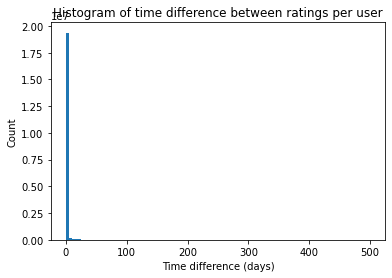

In [43]:
plt.figure()
plt.hist(time_diff_days[time_diff_days <= 500], bins=100)
plt.xlabel('Time difference (days)')
plt.ylabel('Count')
plt.title('Histogram of time difference between ratings per user')
plt.show()

It looks like the time difference is in hours or seconds, let's see:

In [15]:
ratings['time_diff_seconds'] = ratings['time_diff'].dt.total_seconds()

In [47]:
ratings['time_diff_seconds'].describe().round()

count     19861770.0
mean        118438.0
std        2127205.0
min              0.0
25%              3.0
50%             11.0
75%             36.0
max      464596991.0
Name: time_diff_seconds, dtype: float64

In [55]:
print('Median of seconds between ratings per user:')
print(ratings['time_diff_seconds'].median(), 'seconds')

Median of seconds between ratings per user:
11.0 seconds


In [19]:
time_diff_seconds = ratings['time_diff_seconds'].dropna()

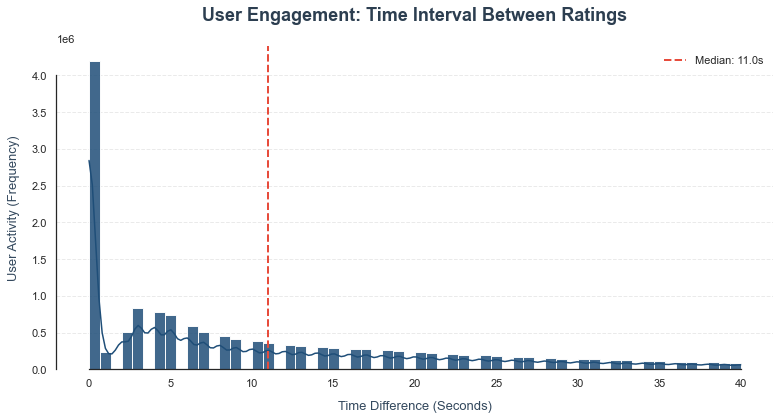

In [21]:
sns.set_theme(style="white") 

plt.figure(figsize=(11, 6))

# Histogram with a smooth density curve
ax = sns.histplot(
    time_diff_seconds[time_diff_seconds <= 40], 
    bins=60, 
    kde=True, 
    color="#1f4e78",     # Deep Navy Blue (Standard Corporate)
    edgecolor="white", 
    alpha=0.85
)

plt.title('User Engagement: Time Interval Between Ratings', fontsize=18, pad=25, fontweight='bold', color='#2c3e50')
plt.xlabel('Time Difference (Seconds)', fontsize=13, labelpad=12, color='#34495e')
plt.ylabel('User Activity (Frequency)', fontsize=13, labelpad=12, color='#34495e')

# Adding a vertical line for the median - adds great context for stakeholders
median_val = ratings['time_diff_seconds'].median()
plt.axvline(median_val, color='#e74c3c', linestyle='--', linewidth=2, label=f'Median: {median_val:.1f}s')

# Refining the grid and removing clutter
plt.grid(axis='y', linestyle='--', alpha=0.4)
sns.despine(trim=True)
plt.legend(frameon=False, fontsize=11)

plt.tight_layout()
plt.show()

Although user interactions occur in short bursts (median gap ≈ 11s), online predictions are triggered by user requests rather than by each interaction. Therefore, I'll combine a micro-batch feature store with request-time features to balance freshness and latency.

### EDA by each user

In [22]:
print('Number of user that made at least one rating:')
print(ratings['userId'].nunique())

Number of user that made at least one rating:
138493


In [59]:
ratings.groupby('userId')['rating'].count().describe()

count    138493.000000
mean        144.413530
std         230.267257
min          20.000000
25%          35.000000
50%          68.000000
75%         155.000000
max        9254.000000
Name: rating, dtype: float64

In [23]:
ratings.groupby('userId')['rating'].count().median()

68.0

- The average number of ratings by each user is: 144
- The median number of ratings by each user is: 68

In [24]:
ratings['year_rating'] = ratings['timestamp'].dt.year

In [25]:
ratings_per_year = (
    ratings
    .groupby('year_rating')
    .size()
    .reset_index(name='num_ratings')
)


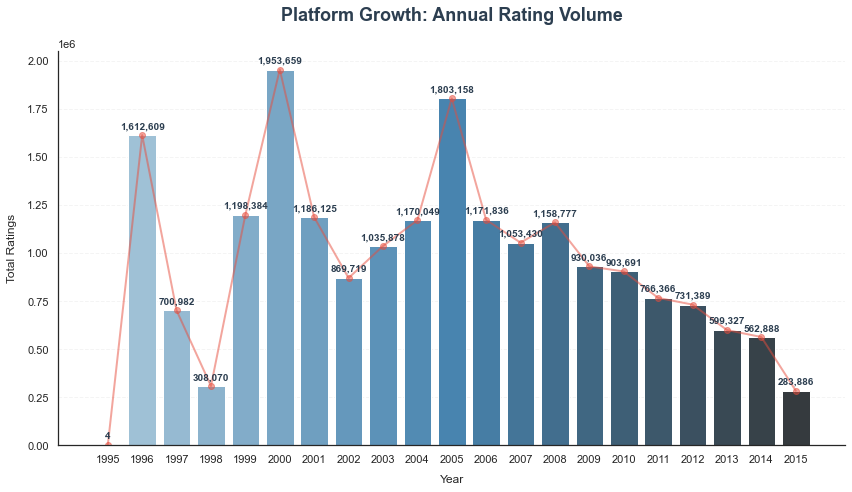

In [28]:

# Set professional style
sns.set_theme(style="white")
plt.figure(figsize=(12, 7))

# 1. Create a color palette manually to avoid 'hue' issues
# This creates a beautiful blue gradient based on the number of bars
n_bars = len(ratings_per_year)
colors = sns.color_palette("Blues_d", n_bars)

# 2. Simple barplot (removing hue and legend to fix your error)
ax = sns.barplot(
    x=ratings_per_year['year_rating'], 
    y=ratings_per_year['num_ratings'],
    palette=colors
)

# Add Data Labels (The numbers on top of bars)
for p in ax.patches:
    ax.annotate(f'{int(p.get_height()):,}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 9), 
                textcoords='offset points',
                fontsize=10, fontweight='bold', color='#2c3e50')

# Add a subtle trend line
plt.plot(
    range(n_bars), 
    ratings_per_year['num_ratings'], 
    color='#e74c3c', linestyle='-', linewidth=2, marker='o', alpha=0.5
)

# Professional Titles
plt.title('Platform Growth: Annual Rating Volume', fontsize=18, pad=30, fontweight='bold', color='#2c3e50')
plt.xlabel('Year', fontsize=12, labelpad=10)
plt.ylabel('Total Ratings', fontsize=12, labelpad=10)

# Clean up the visual "noise"
sns.despine()
plt.grid(axis='y', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

The tendency is that in recent years the total number of ratings has been declined.

## EDA Movies

In [29]:
movies[movies['title'].isin(movies[movies.duplicated(['title'])]['title'].values)].sort_values('title')

,movieId,title,genres
24064,114130,"20,000 Leagues Under the Sea (1997)",Romance|Sci-Fi
20923,102190,"20,000 Leagues Under the Sea (1997)",Adventure|Romance|Sci-Fi
582,588,Aladdin (1992),Adventure|Animation|Children|Comedy|Musical
24092,114240,Aladdin (1992),Adventure|Animation|Children|Comedy|Fantasy
24437,115777,Beneath (2013),Horror
21429,104035,Beneath (2013),Horror
13417,66140,Blackout (2007),Horror|Thriller
16827,85070,Blackout (2007),Drama
26808,128862,Casanova (2005),Comedy|Drama|Romance
10694,42015,Casanova (2005),Action|Adventure|Comedy|Drama|Romance


In [31]:
generos_expandidos = movies['genres'].str.split('|').explode()
conteo_generos = generos_expandidos.value_counts()

print(conteo_generos)

Drama                 13344
Comedy                 8374
Thriller               4178
Romance                4127
Action                 3520
Crime                  2939
Horror                 2611
Documentary            2471
Adventure              2329
Sci-Fi                 1743
Mystery                1514
Fantasy                1412
War                    1194
Children               1139
Musical                1036
Animation              1027
Western                 676
Film-Noir               330
(no genres listed)      246
IMAX                    196
Name: genres, dtype: int64


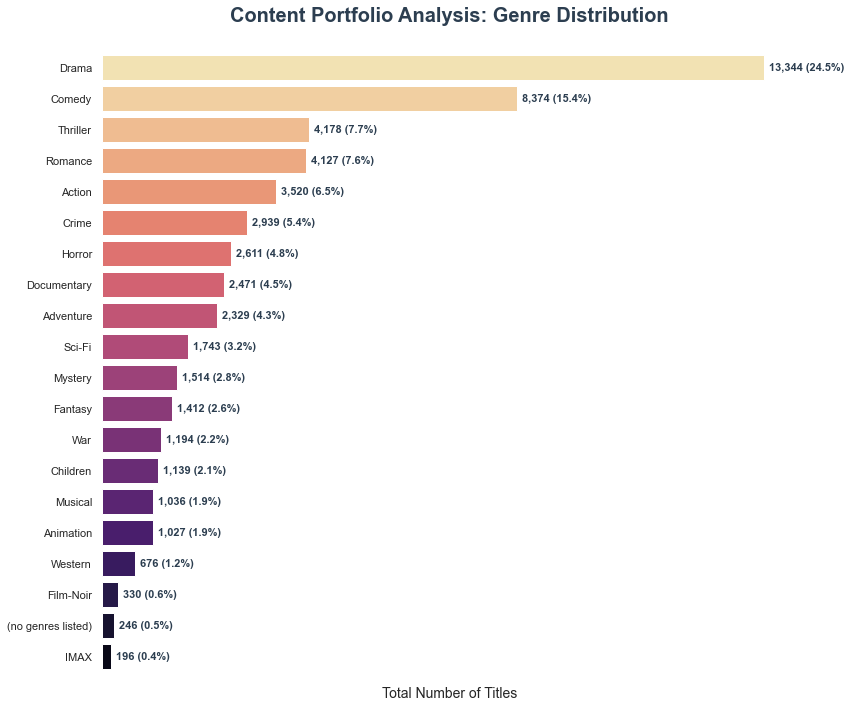

In [36]:
total = sum(conteo_generos)

# Styling
sns.set_theme(style="white")
plt.figure(figsize=(12, 10))

# Horizontal bar plot
# 'magma_r' gives a professional sunset gradient (dark for high values)
colors = sns.color_palette("magma_r", len(conteo_generos))
ax = sns.barplot(x=conteo_generos.values, y=conteo_generos.index, palette=colors)

# --- Executive Annotations ---
for i, p in enumerate(ax.patches):
    width = p.get_width()
    percentage = (width / total) * 100
    ax.text(
        width + 100,            # Position text slightly to the right of the bar
        p.get_y() + p.get_height()/2, 
        f'{int(width):,} ({percentage:.1f}%)', 
        va='center', fontsize=11, color='#2c3e50', fontweight='bold'
    )

# Formatting
plt.title('Content Portfolio Analysis: Genre Distribution', fontsize=20, pad=30, fontweight='bold', color='#2c3e50')
plt.xlabel('Total Number of Titles', fontsize=14, labelpad=15)
plt.ylabel('', fontsize=14) # Genre names are clear, no need for Y label

# Clean up
sns.despine(left=True, bottom=True)
plt.xticks([]) # Hide X-axis numbers because data labels are on the bars
plt.tight_layout()

plt.show()